<a href="https://colab.research.google.com/github/Akhil-Raj/SIH2019-SharedRooftopRainwaterHarvesting/blob/master/Rainfall_Prediction_SIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [0]:
dataset = pd.read_csv('drive/My Drive/Daily Rainfall dataset Chittagong.csv')

dataset=dataset.fillna(0)

In [6]:
dataset.head()

,year,month,day,tempHigh,tempAvg,tempLow,DPHigh,DPAvg,DPLow,humidityHigh,humidityAvg,humidityLow,SLPHigh,SLPAvg,SLPLow,visibilityHigh,visibilityAvg,visibilityLow,windAvg,Rainfall
0,2012,1,1,28,23,19,18,14,10,88,57,34,1015,1012,1010,6,5,4,5,0.0
1,2012,1,2,26,22,18,17,15,13,88,65,47,1015,1013,1012,4,3,2,2,0.0
2,2012,1,3,27,22,17,20,17,16,94,71,54,1014,1012,1010,5,4,4,6,0.0
3,2012,1,4,26,23,20,18,17,15,83,66,51,1015,1013,1010,4,3,1,3,0.0
4,2012,1,5,26,23,19,18,17,16,88,71,57,1016,1014,1012,4,3,1,3,0.0


In [0]:
dataset['date'] = dataset['day'].apply(str) + "-" + dataset['month'].apply(str) + "-" + dataset['year'].apply(str)
dataset['date'] = pd.to_datetime(dataset['date'])

In [0]:
df = dataset[['Rainfall','date']]

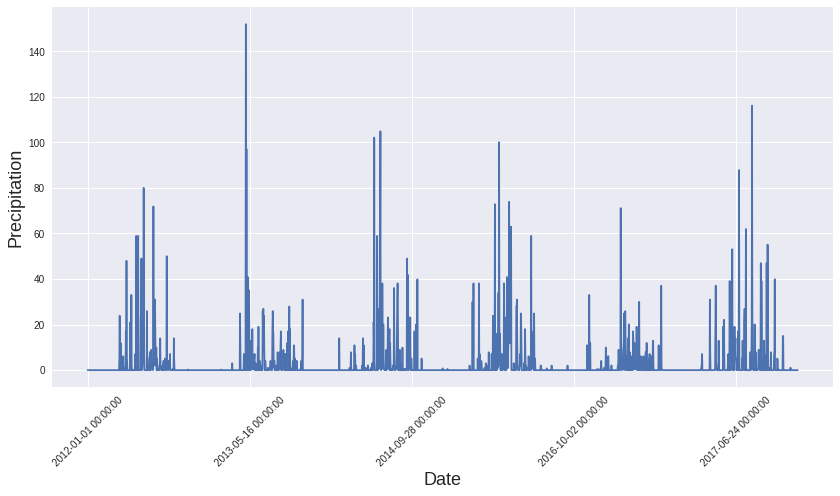

In [9]:
plt.figure(figsize = (14,7))
plt.plot(range(df.shape[0]),df['Rainfall'])
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Precipitation',fontsize=18)
plt.show()

**Splitting the dataset into train and test dataset to predict rainfall**

In [0]:
test_size = 365 #Last year for prediction of rainfall
train_size = df.shape[0]-test_size
train_df = df[:train_size]
test_df = df[train_size:]

**Normalizing Data for prediction**

In [0]:
scaler = MinMaxScaler()

train_df = train_df['Rainfall'].values
test_df = test_df['Rainfall'].values
train_df = train_df.reshape(-1,1)
test_df = test_df.reshape(-1,1)

In [0]:
#Normalize the train data
scaler.fit(train_df[:train_size,:])
train_df[:train_size,:] = scaler.transform(train_df[:train_size,:])

In [32]:
train_df.shape, test_df.shape

((1826, 1), (365, 1))

In [0]:
# Reshape both train and test data
train_df = train_df.reshape(-1)

# Normalize the test data
test_df = scaler.transform(test_df).reshape(-1)

In [0]:
EMA = 0.0
gamma = 0.1
for ti in range(train_df.shape[0]):
  EMA = gamma*train_df[ti] + (1-gamma)*EMA
  train_df[ti] = EMA

# Used for visualization and test purposes
all_data = np.concatenate([train_df,test_df],axis=0)

In [35]:
window_size = 182
N = train_df.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
  
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    running_mean = running_mean*decay + (1.0-decay)*train_df[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_df[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


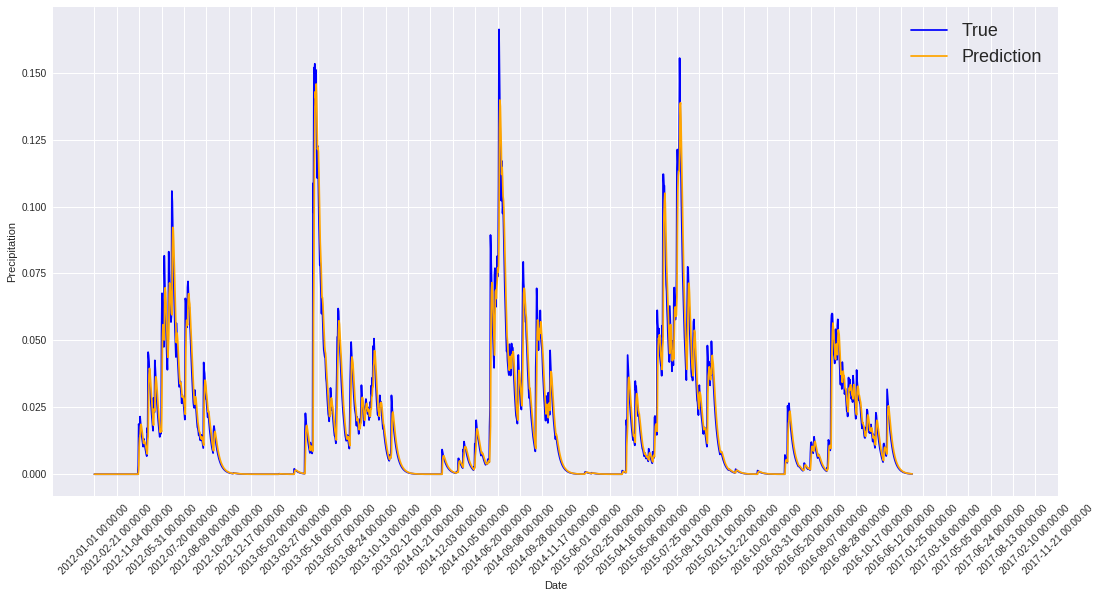

In [38]:
plt.figure(figsize = (18,9))
plt.plot(range(N),all_data[:N],color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(fontsize=18)
plt.show()

**LSTM Model**

In [0]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [0]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [0]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [0]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [0]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [0]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [0]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [0]:
raw_values = df['Rainfall'].values
diff_values = difference(raw_values, 1)

In [0]:
# to transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [0]:
# split data into train and test-sets
train, test = supervised_values[0:-365], supervised_values[-365:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [22]:
# repeat experiment
repeats = 5
error_scores = list()
for r in range(repeats):
  print("Repeat number: ",r)
  # fit the model
  lstm_model = fit_lstm(train_scaled, 1, 10, 4)
  # forecast the entire training dataset to build up state for forecasting
  train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
  lstm_model.predict(train_reshaped, batch_size=1)
  # walk-forward validation on the test data
  predictions = list()
  for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
  # report performance
  rmse = sqrt(mean_squared_error(raw_values[-365:], predictions))
  print('%d) Test RMSE: %.3f' % (r+1, rmse))
  error_scores.append(rmse)

Repeat number:  0
1) Test RMSE: 12.498
Repeat number:  1
2) Test RMSE: 13.951
Repeat number:  2
3) Test RMSE: 12.139
Repeat number:  3
4) Test RMSE: 14.104
Repeat number:  4
5) Test RMSE: 12.594


            rmse
count   5.000000
mean   13.835267
std     2.797219
min    11.721513
25%    12.391339
50%    12.736961
75%    13.643392
max    18.683129


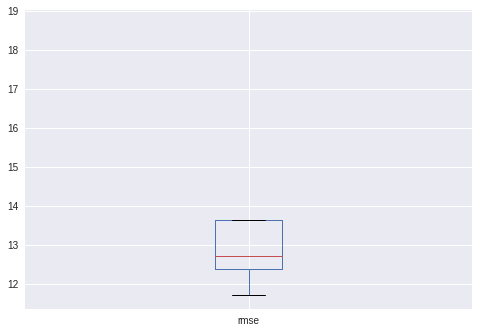

In [59]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

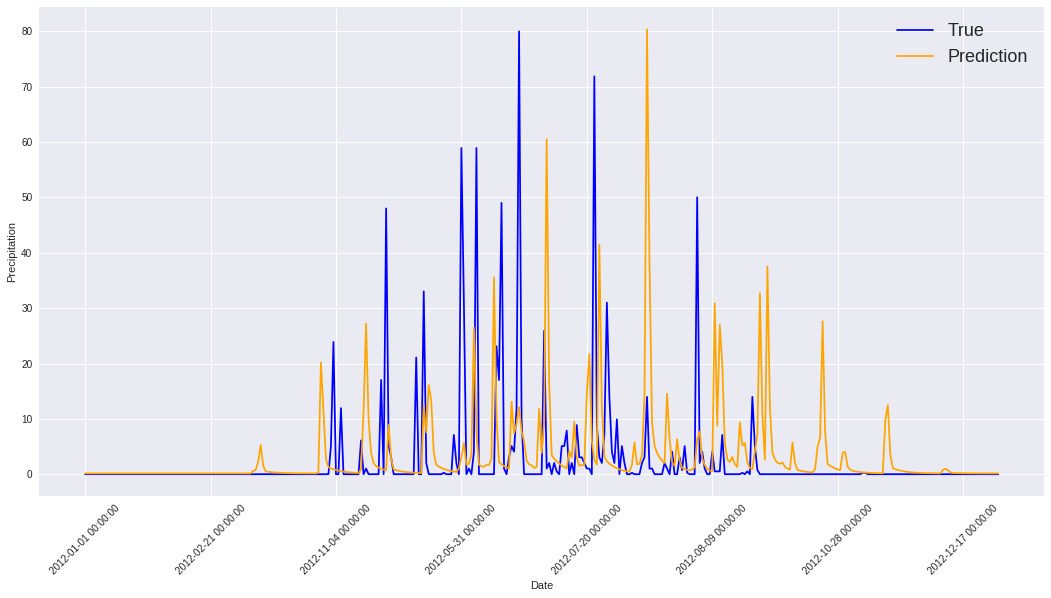

In [28]:
plt.figure(figsize = (18,9))
plt.plot(range(0,test_df.shape[0]),raw_values[:test_df.shape[0]],color='b',label='True')
plt.plot(range(0,test_df.shape[0]),predictions,color='orange', label='Prediction')
plt.xticks(range(0,test_df.shape[0],50),df['date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(fontsize=18)
plt.show()

In [50]:
dummy_test = np.array([0.6])
dummy_test = dummy_test.reshape(1,1,1)
lstm_model.predict(dummy_test, batch_size=1)

array([[0.36655027]], dtype=float32)